In [16]:
# 02_build_graph.ipynb — Cell 1
import os
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import json

# Load the cleaned dataframe produced in 01_load_and_clean.ipynb
# If you didn't save df to disk, run this in the SAME kernel/session where df already exists,



In [17]:
# ---- Load cleaned professor data ----

df = pd.read_json("../data/processed/cleaned_professors.json")

print("Data loaded successfully")
print(df.shape)
print(df.columns)
df.head(2)


Data loaded successfully
(1228, 2)
Index(['clean_text', 'professor_dict'], dtype='object')


,clean_text,professor_dict
0,has worked as a designer for the last decade i...,{'Corporate Experience - Organization': ['A&M ...
1,Mr. Madgar has been teaching economics part ti...,{'Corporate Experience - Organization': ['Bemi...


In [ ]:


# ---- Build nodes & edges from professor_dict ----
G = nx.Graph()

def add_node_if_missing(node_id, **attrs):
    if not G.has_node(node_id):
        G.add_node(node_id, **attrs)

def add_edge(u, v, **attrs):
    if not G.has_edge(u, v):
        G.add_edge(u, v, **attrs)
    else:
        # merge categories if same pair appears in multiple roles
        existing = G[u][v]
        for k, val in attrs.items():
            if k == "roles":
                existing.setdefault("roles", set()).update(val)
            else:
                existing[k] = val

# Try to use 'name' if present; else fallback to index label
name_col = "name" if "name" in df.columns else None

for i, row in df.iterrows():
    prof_id = f"PROF::{i}"
    prof_label = row[name_col] if name_col and pd.notna(row[name_col]) else f"Professor {i}"
    add_node_if_missing(prof_id, label=prof_label, ntype="PROFESSOR")

    d = row.get("professor_dict", {}) or {}

    # Buckets we currently fill
    corp_orgs = d.get("Corporate Experience - Organization", []) or []
    corp_locs = d.get("Corporate Experience - Location", []) or []
    acad_orgs = d.get("Academic Background - Organization", []) or []
    degrees   = d.get("Academic Background - Education", []) or []
    subjects  = d.get("Academic Experience - Subjects", []) or []

    # ORG nodes (Corporate)
    for org in set([o for o in corp_orgs if isinstance(o, str) and len(o.strip()) > 2]):
        org_id = f"ORG::{org}"
        add_node_if_missing(org_id, label=org, ntype="ORG")
        add_edge(prof_id, org_id, roles={"CorporateOrg"})

    # LOC nodes (Corporate)
    for loc in set([l for l in corp_locs if isinstance(l, str) and len(l.strip()) > 1]):
        loc_id = f"LOC::{loc}"
        add_node_if_missing(loc_id, label=loc, ntype="LOC")
        add_edge(prof_id, loc_id, roles={"CorporateLoc"})

    # ORG nodes (Academic Background)
    for org in set([o for o in acad_orgs if isinstance(o, str) and len(o.strip()) > 2]):
        org_id = f"ORG::{org}"
        add_node_if_missing(org_id, label=org, ntype="ORG")
        add_edge(prof_id, org_id, roles={"AcademicOrg"})

    # Education nodes
    for deg in set([e for e in degrees if isinstance(e, str) and len(e.strip()) > 1]):
        deg_id = f"EDU::{deg}"
        add_node_if_missing(deg_id, label=deg, ntype="EDU")
        add_edge(prof_id, deg_id, roles={"Education"})

    # Subject nodes
    for sub in set([s for s in subjects if isinstance(s, str) and len(s.strip()) > 1]):
        sub_id = f"SUB::{sub}"
        add_node_if_missing(sub_id, label=sub, ntype="SUBJECT")
        add_edge(prof_id, sub_id, roles={"Subject"})

# ---- Quick stats ----
node_types = pd.Series(nx.get_node_attributes(G, "ntype")).value_counts()
print("Node counts by type:\n", node_types.to_string(), "\n")
print("Total nodes:", G.number_of_nodes(), "  Total edges:", G.number_of_edges())

# Top connected ORGs/LOCs
deg = dict(G.degree())
top_orgs = sorted([(n, deg[n]) for n, d in G.nodes(data=True) if d.get("ntype")=="ORG"], key=lambda x: x[1], reverse=True)[:15]
top_locs = sorted([(n, deg[n]) for n, d in G.nodes(data=True) if d.get("ntype")=="LOC"], key=lambda x: x[1], reverse=True)[:15]
print("\nTop ORGs by degree:")
for n, k in top_orgs: print(nx.get_node_attributes(G,"label")[n], "->", k)
print("\nTop LOCs by degree:")
for n, k in top_locs: print(nx.get_node_attributes(G,"label")[n], "->", k)

# ---- Save artifacts ----
os.makedirs("../outputs/graph", exist_ok=True)


Node counts by type:
 ORG          5476
SUBJECT      1421
PROFESSOR    1228
LOC           789
EDU           334 

Total nodes: 9248   Total edges: 14191

Top ORGs by degree:
Academic Ba -> 83
Academic Bac -> 78
Universidad Complutense de Madrid -> 72
Universidad Autónoma De Madrid -> 52
Universidad Pontificia Comillas -> 48
Universidad Politécnica De Madrid -> 43
Harvard University -> 38
IESE Business School -> 33
Universidad Complutense -> 32
Universidad Autónoma de Madrid -> 27
Harvard Business School -> 24
Universidad Pontificia De Comillas -> 23
Climate Action -> 23
Complutense University Of Madrid -> 22
University Of Oxford -> 18

Top LOCs by degree:
Spain -> 484
Madrid -> 148
United States -> 90
London -> 51
Portugal -> 42
Germany -> 39
France -> 38
New York -> 34
Italy -> 30
Switzerland -> 30
Europe -> 28
United Kingdom -> 23
Mexico -> 20
Barcelona -> 19
Paris -> 19


In [19]:
# ---- Sanitize node and edge attributes before export ----
for n, data in G.nodes(data=True):
    for k, v in data.items():
        if isinstance(v, set):
            data[k] = list(v)
        elif not isinstance(v, (str, int, float, list, dict)):
            data[k] = str(v)

for u, v, data in G.edges(data=True):
    for k, v2 in data.items():
        if isinstance(v2, set):
            data[k] = list(v2)
        elif not isinstance(v2, (str, int, float, list, dict)):
            data[k] = str(v2)


In [20]:
# ---- Sanitize node/edge attributes for GraphML ----
import json

def _coerce_for_graphml(val):
    # GraphML supports string/float/int/bool; not list/set/dict
    if isinstance(val, (set, tuple)):
        return json.dumps(list(val), ensure_ascii=False)
    if isinstance(val, (list, dict)):
        return json.dumps(val, ensure_ascii=False)
    if isinstance(val, (str, int, float, bool)) or val is None:
        return val
    return str(val)

# Nodes
for n, data in G.nodes(data=True):
    for k in list(data.keys()):
        data[k] = _coerce_for_graphml(data[k])

# Edges (works for DiGraph/Graph; tweak slightly if MultiGraph)
for u, v, data in G.edges(data=True):
    for k in list(data.keys()):
        data[k] = _coerce_for_graphml(data[k])


In [21]:

# GraphML (good for Gephi)
nx.write_graphml(G, "../outputs/graph/prof_kg.graphml")


In [22]:
# Also export GEXF (Gephi) and CSVs
nx.write_gexf(G, "../outputs/graph/prof_kg.gexf")

nodes_df = pd.DataFrame(
    [(n, d.get("label"), d.get("ntype")) for n, d in G.nodes(data=True)],
    columns=["node_id","label","type"]
)
edges_df = pd.DataFrame(
    [(u, v, d.get("rel")) for u, v, d in G.edges(data=True)],
    columns=["source","target","relation"]
)
nodes_df.to_csv("../outputs/graph/nodes.csv", index=False)
edges_df.to_csv("../outputs/graph/edges.csv", index=False)



Saved:
 - ../outputs/graph/prof_kg.graphml
 - ../outputs/graph/nodes.csv
 - ../outputs/graph/edges.csv


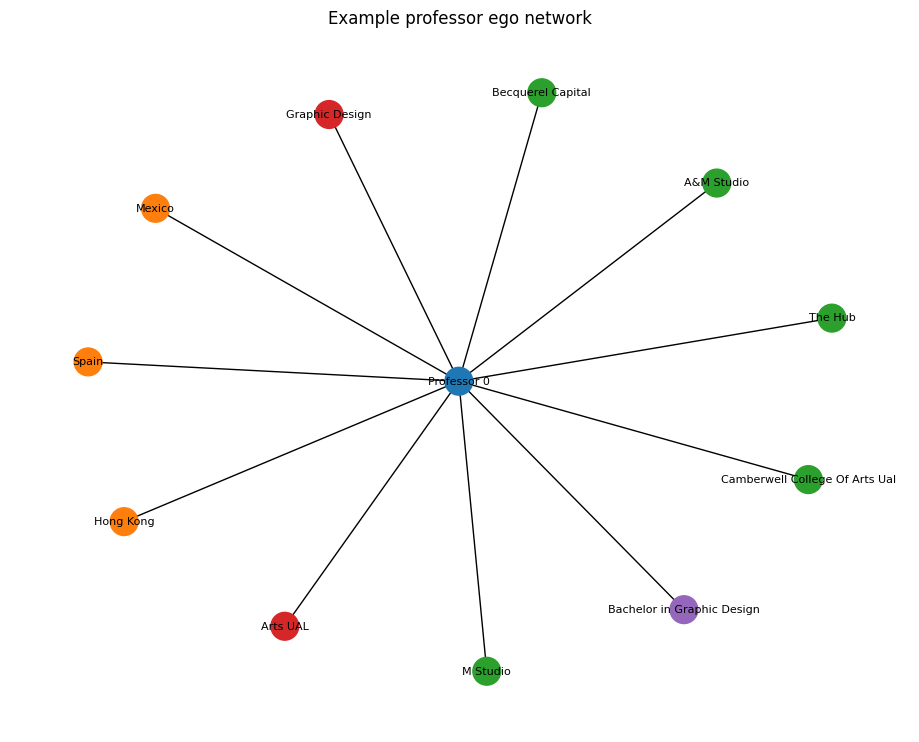

In [23]:


# Node/edge tables for your report
nodes_df = pd.DataFrame([(n, d.get("label"), d.get("ntype")) for n, d in G.nodes(data=True)],
                        columns=["node_id","label","type"])
edges_df = pd.DataFrame([(u, v, sorted(list(attr.get("roles", set())))) for u, v, attr in G.edges(data=True)],
                        columns=["source","target","roles"])

nodes_df.to_csv("../outputs/graph/nodes.csv", index=False)
edges_df.to_csv("../outputs/graph/edges.csv", index=False)

print("\nSaved:")
print(" - ../outputs/graph/prof_kg.graphml")
print(" - ../outputs/graph/nodes.csv")
print(" - ../outputs/graph/edges.csv")

# ---- (Optional) Tiny visualization: pick one professor ego network ----
try:
    sample_prof = next(n for n, d in G.nodes(data=True) if d.get("ntype")=="PROFESSOR")
    ego = nx.ego_graph(G, sample_prof, radius=1)
    plt.figure(figsize=(9,7))
    pos = nx.spring_layout(ego, seed=42)
    colors = []
    for n in ego.nodes():
        t = G.nodes[n].get("ntype")
        colors.append({"PROFESSOR": "tab:blue", "ORG":"tab:green", "LOC":"tab:orange", "EDU":"tab:purple", "SUBJECT":"tab:red"}.get(t, "tab:gray"))
    nx.draw(ego, pos, with_labels=True,
            labels=nx.get_node_attributes(ego, "label"),
            node_color=colors, node_size=400, font_size=8)
    plt.title("Example professor ego network")
    plt.show()
except StopIteration:
    print("No professor nodes to visualize.")


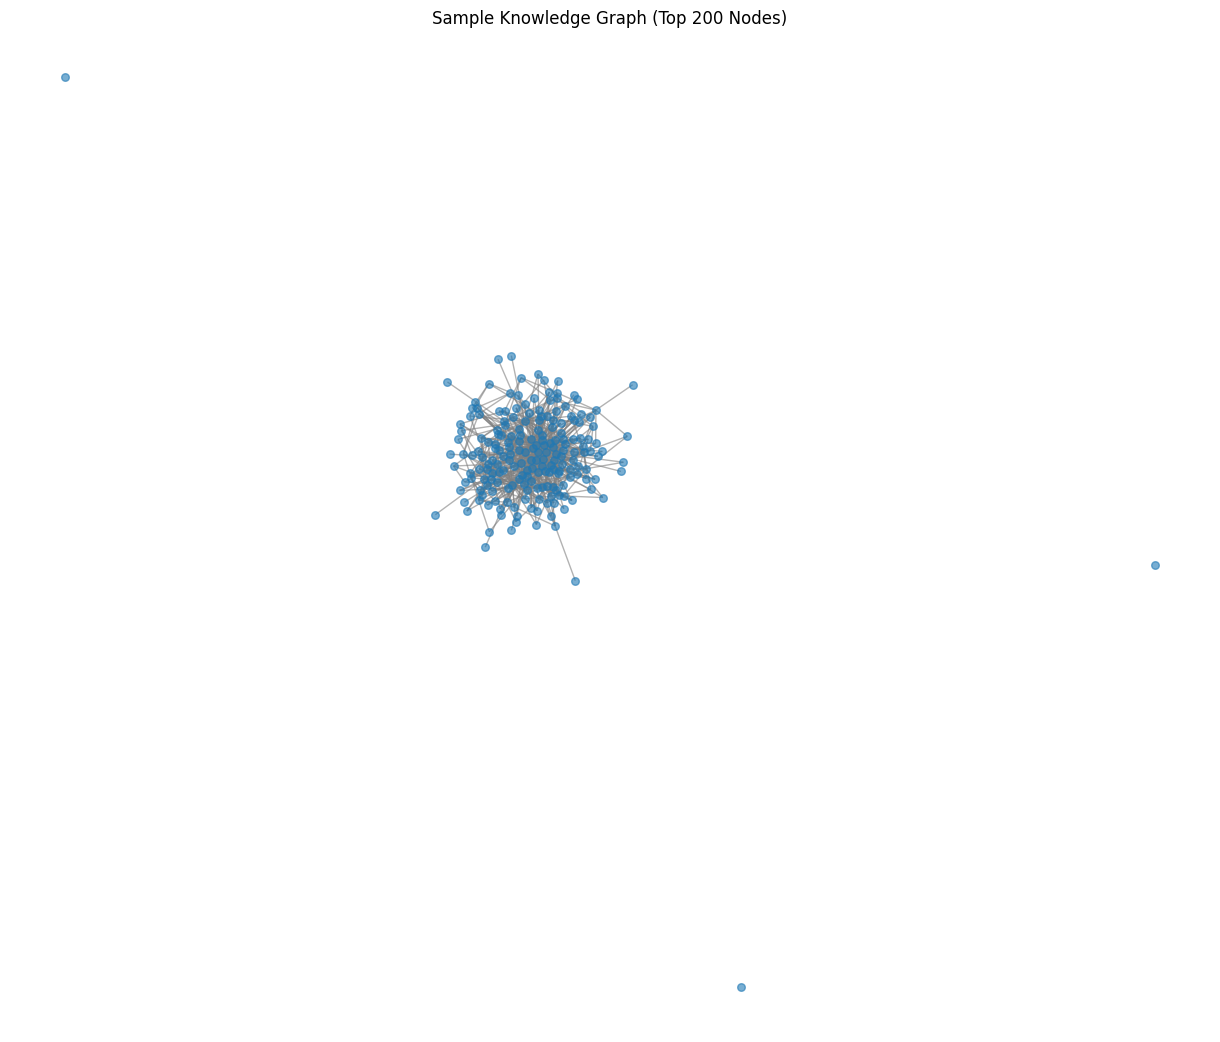

In [24]:
import matplotlib.pyplot as plt
import networkx as nx

# pick a manageable subset (e.g., top 200 most connected nodes)
sub_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)[:200]
H = G.subgraph([n for n, _ in sub_nodes])

plt.figure(figsize=(12, 10))
pos = nx.spring_layout(H, seed=42)
nx.draw(
    H,
    pos,
    with_labels=False,
    node_size=30,
    edge_color="gray",
    alpha=0.6,
)
plt.title("Sample Knowledge Graph (Top 200 Nodes)")
plt.show()


In [26]:
import os
import networkx as nx

# ---- Export a smaller sample subgraph for Gephi ----
# Select the top 300 most connected nodes for a lighter graph
sub_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)[:50]
H = G.subgraph([n for n, _ in sub_nodes])

os.makedirs("../outputs/graph", exist_ok=True)
sample_path = "../outputs/graph/prof_kg_sample.graphml"

# Sanitize node/edge attributes (GraphML safe)
for n, data in H.nodes(data=True):
    for k, v in data.items():
        if isinstance(v, (set, list, dict)):
            data[k] = str(v)
for u, v, data in H.edges(data=True):
    for k, v2 in data.items():
        if isinstance(v2, (set, list, dict)):
            data[k] = str(v2)

# Save for Gephi
nx.write_graphml(H, sample_path)
print(f"Sample graph saved to: {sample_path}")
print(f"Nodes: {H.number_of_nodes()}  Edges: {H.number_of_edges()}")


Sample graph saved to: ../outputs/graph/prof_kg_sample.graphml
Nodes: 50  Edges: 95
